In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(0, os.environ['PLOT_SETTINGS_DIR'])
import plot_settings
import matplotlib as mpl
import networkx as nx
import matplotlib.ticker as tk
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24

def read_gset(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        # h /= J.abs().max()
        # J /= J.abs().max()
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G


In [2]:
import pandas as pd
idir = '../data'

def make_tts_df(df: pd.DataFrame, cols=[], groupcols=[], 
                targets=[0.9999999, 0.995], 
                metrics=[('TTT', 'anneal')], 
                sort_metric='TTT'):
    dataframes = []
    for targ in targets:
        # print(df[''])
        df[f'GS'] = df['Ratio'] >= targ
        mean_df = df.groupby(['graph'] + cols + groupcols).mean(numeric_only=True).reset_index()
        mean_df['target'] = targ
        mean_df['factor'] = 1
        badind = (mean_df[f'GS'] < 0.99) & (mean_df[f'GS'] > 1e-10)
        prob = np.array(mean_df.loc[badind][f'GS'])
        mean_df.loc[badind, 'factor'] = np.log10(0.01) / np.log10(1-prob)
        for field, metric in metrics:
            mean_df[f'{field}'] =  mean_df[metric]
            metarr =  np.array(mean_df.loc[badind][metric])
            mean_df.loc[badind, f'{field}'] = metarr * mean_df.loc[badind, 'factor']
            mean_df.loc[(mean_df[f'GS'] <= 1e-10), f'{field}'] = np.inf
            tts_df = mean_df.sort_values(by=sort_metric).drop_duplicates(
                ['graph', 'target']
+cols)
            dataframes.append(tts_df)
    return pd.concat(dataframes)


In [ ]:
longer_df = pd.read_csv('../data/bw_vs_energy_longer.csv')
def gettype(index):
    if index < 35:
        return 'ER'
    return 'BA'
gettype = np.vectorize(gettype)
bks_df = pd.read_csv(os.environ['GSET']+'/bks/set_summary.csv')
longer_df = longer_df.merge(bks_df, on='graph')
longer_df['Ratio'] = longer_df['cut'] / longer_df['BKS']
longer_df['bits'] = longer_df['tstop'] / longer_df['tpart'] * 2000
df = make_tts_df(longer_df, cols=['tpart',  'blocks'], groupcols=['tstop'], targets=[0.98], metrics=[('TTT', 'tstop'),  ('BTT', 'bits') ])
df['GInd'] = df['graph'].str.extract(r'G(\d+)').astype(int)
df['Type'] = gettype(df['GInd'])
df.to_csv('../data/bw_vs_energy_longer_ttt.csv', index=False)

/tmp/ipykernel_155026/1074725261.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 34.48754705  16.00784556   7.70305314   3.32192809   2.21461873
   1.77787459  89.78113496  16.00784556   8.3218161    6.18608249
   2.           1.2483927    1.2483927    9.79815878   3.08728933
   2.           2.           1.2483927    2.86135312   1.53724357
   1.77787459   1.2483927    2.42745331   1.53724357   1.53724357
   2.86135312   1.2483927    2.64214073   1.2483927    1.2483927
   2.42745331   2.42745331   1.2483927    1.2483927    3.56717786
   1.77787459   1.2483927    1.2483927    1.53724357  11.71672059
   4.09738132   2.42745331   1.53724357   2.86135312   1.77787459
   1.2483927    1.2483927   23.93889316   9.0151511    4.6951803
   2.21461873   6.64385619   2.21461873   1.77787459   1.53724357
  23.93889316  14.32028823   5.02588319  18.0671252    5.02588319
   3.08728933   2.64214073 181.89450638  

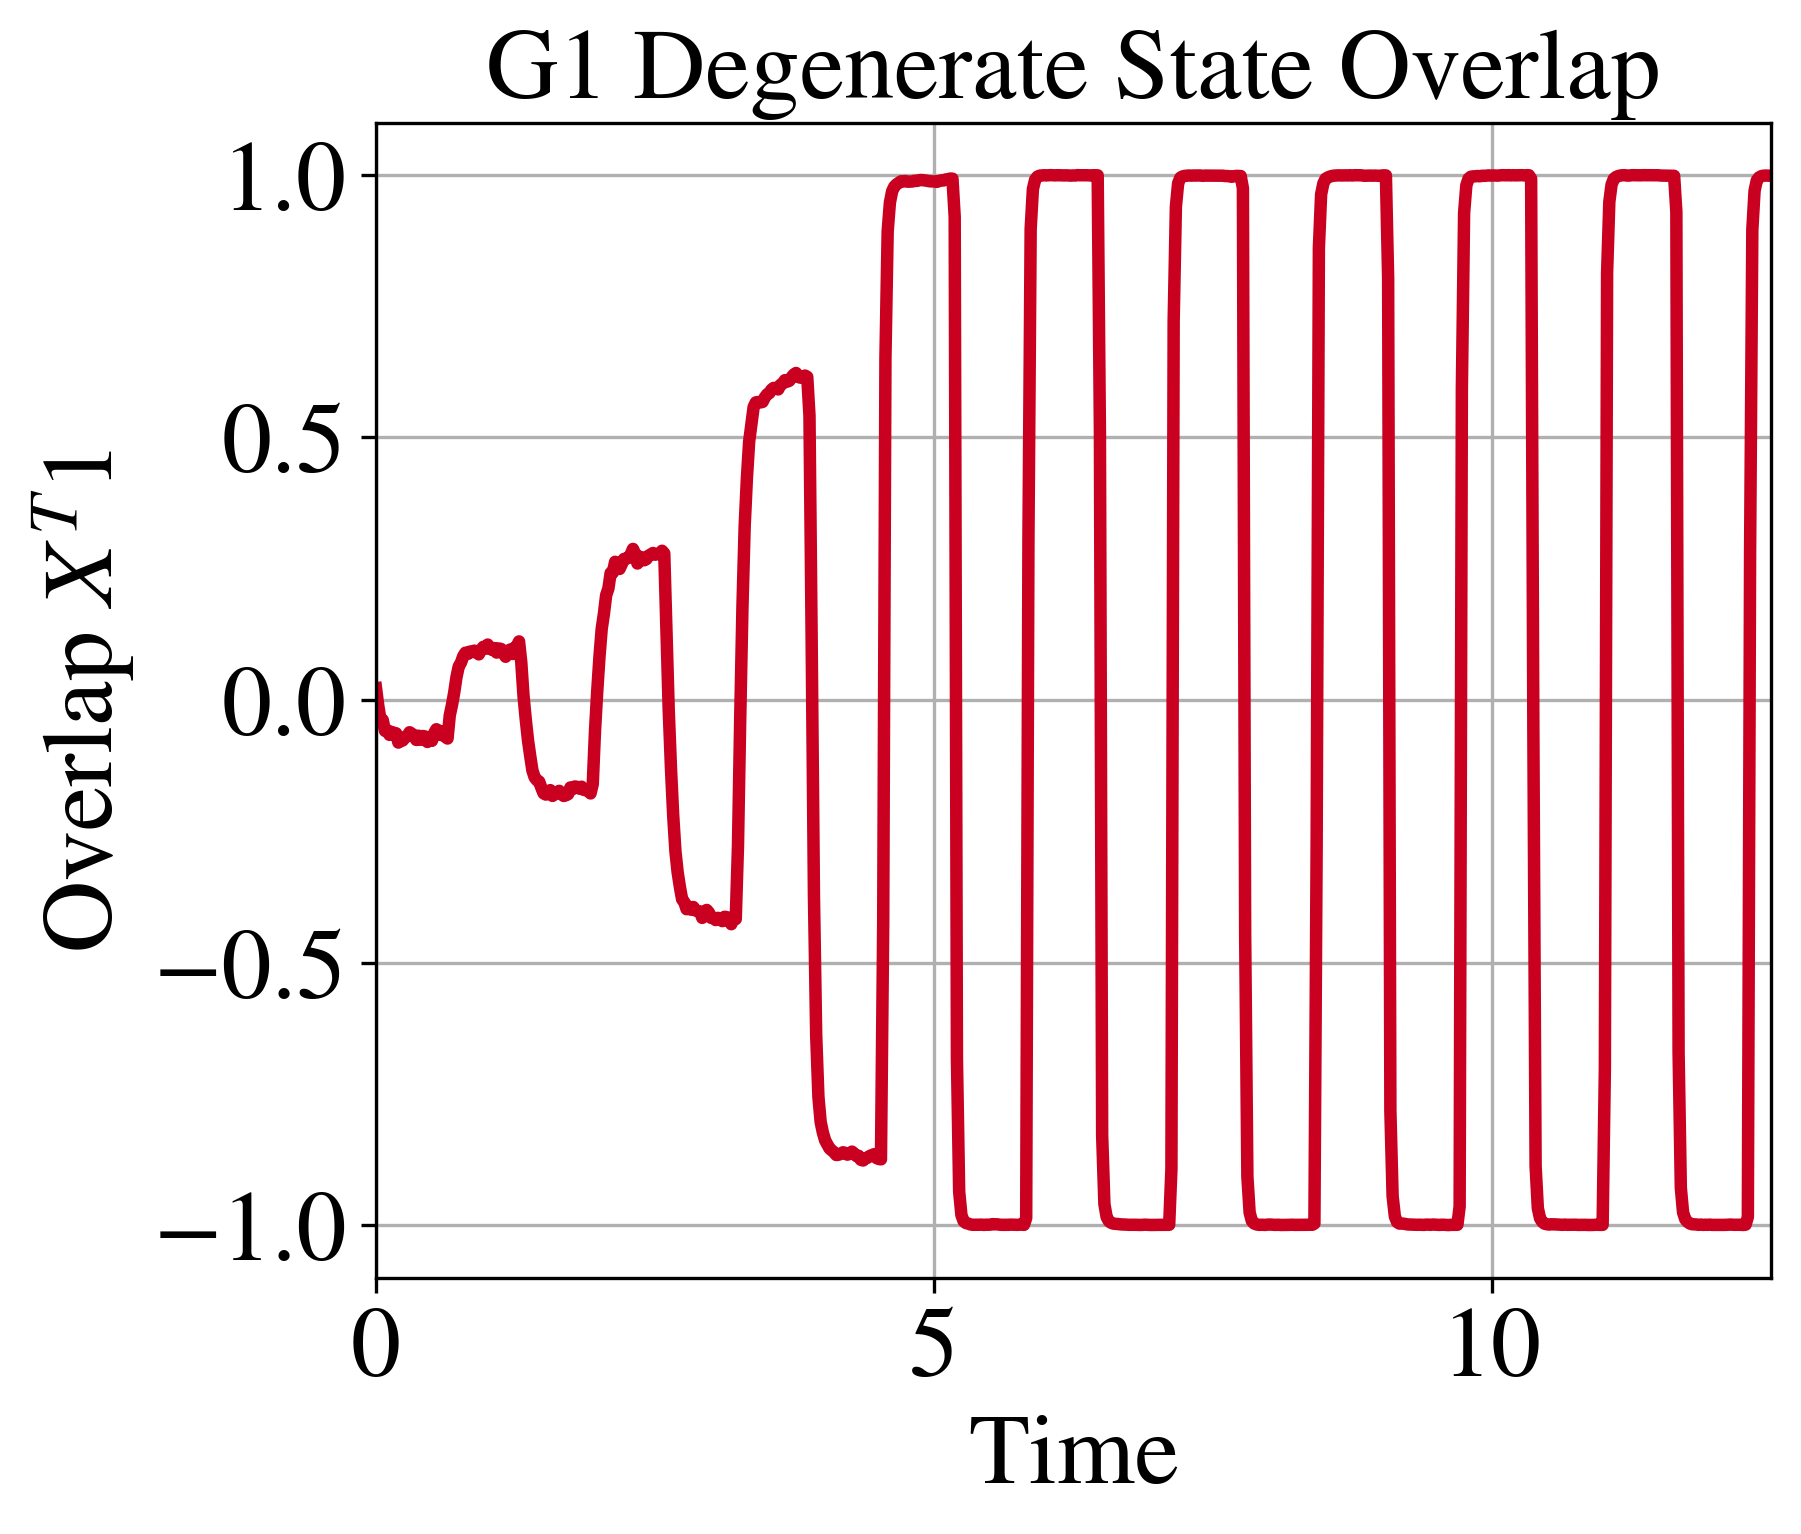

In [4]:
df = pd.read_csv('../g1_overlap.csv')
# df
fig, ax= plt.subplots(figsize=(6,5))
ax=sns.lineplot(data=df, x='time', y='overlap', linewidth=3, color="#ca0020")
ax.set_ylabel('Overlap $X^T$1')
ax.set_xlabel('Time')
ax.set_title('G1 Degenerate State Overlap', fontsize=24)

ax.set_xlim(0,12.5)
ax.grid()
fig.savefig('../figures/g1_overlap.pdf', bbox_inches='tight')

In [5]:
ttt_df

NameError: name 'ttt_df' is not defined

In [ ]:
ttt_df['concurrent']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
835    0.0
836    0.0
837    0.0
838    0.0
839    0.0
Name: concurrent, Length: 840, dtype: object

In [6]:
import re
from scipy.stats import pmean
def get_mean_eigvalue(gname: str):
    G = read_gset(os.environ['GSET']+f'/set/{gname}')
    A = nx.adjacency_matrix(G).toarray()
    eigvals = np.linalg.eigvalsh(A)
    return np.mean(np.abs(eigvals)), pmean(np.abs(eigvals), 2), np.max(np.abs(eigvals))
ttt_df = pd.read_csv('../data/bw_vs_energy_longer_ttt.csv')
ttt_df = pd.concat([ pd.read_csv('../data/bw_vs_energy_ttt98.csv').query('concurrent==1'), pd.read_csv('../data/bw_vs_energy_longer_ttt.csv')]).reset_index()
# ttt_df = pd.read_csv('../data/bw_vs_energy_ttt98.csv')
# ttt_df = ttt_df.sort_values(by='TTT').drop_duplicates(subset=['graph', 'blocks', 'concurrent', 'tpart'])
eig_data = []
for g in ttt_df['graph'].unique():
    gind = int(re.findall(r'G(\d+)', g)[0])
    eig_data.append((g, *get_mean_eigvalue(g), 'BA' if gind > 35 else 'ER'))
eig_df = pd.DataFrame(eig_data, columns=['graph', 'eigmean', 'eigpmean2', 'eigmax', 'type'])

In [ ]:
# Complex Oscillator Dynamics for Polynomial Binary Optimization

(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)
(20.0, 0.0)


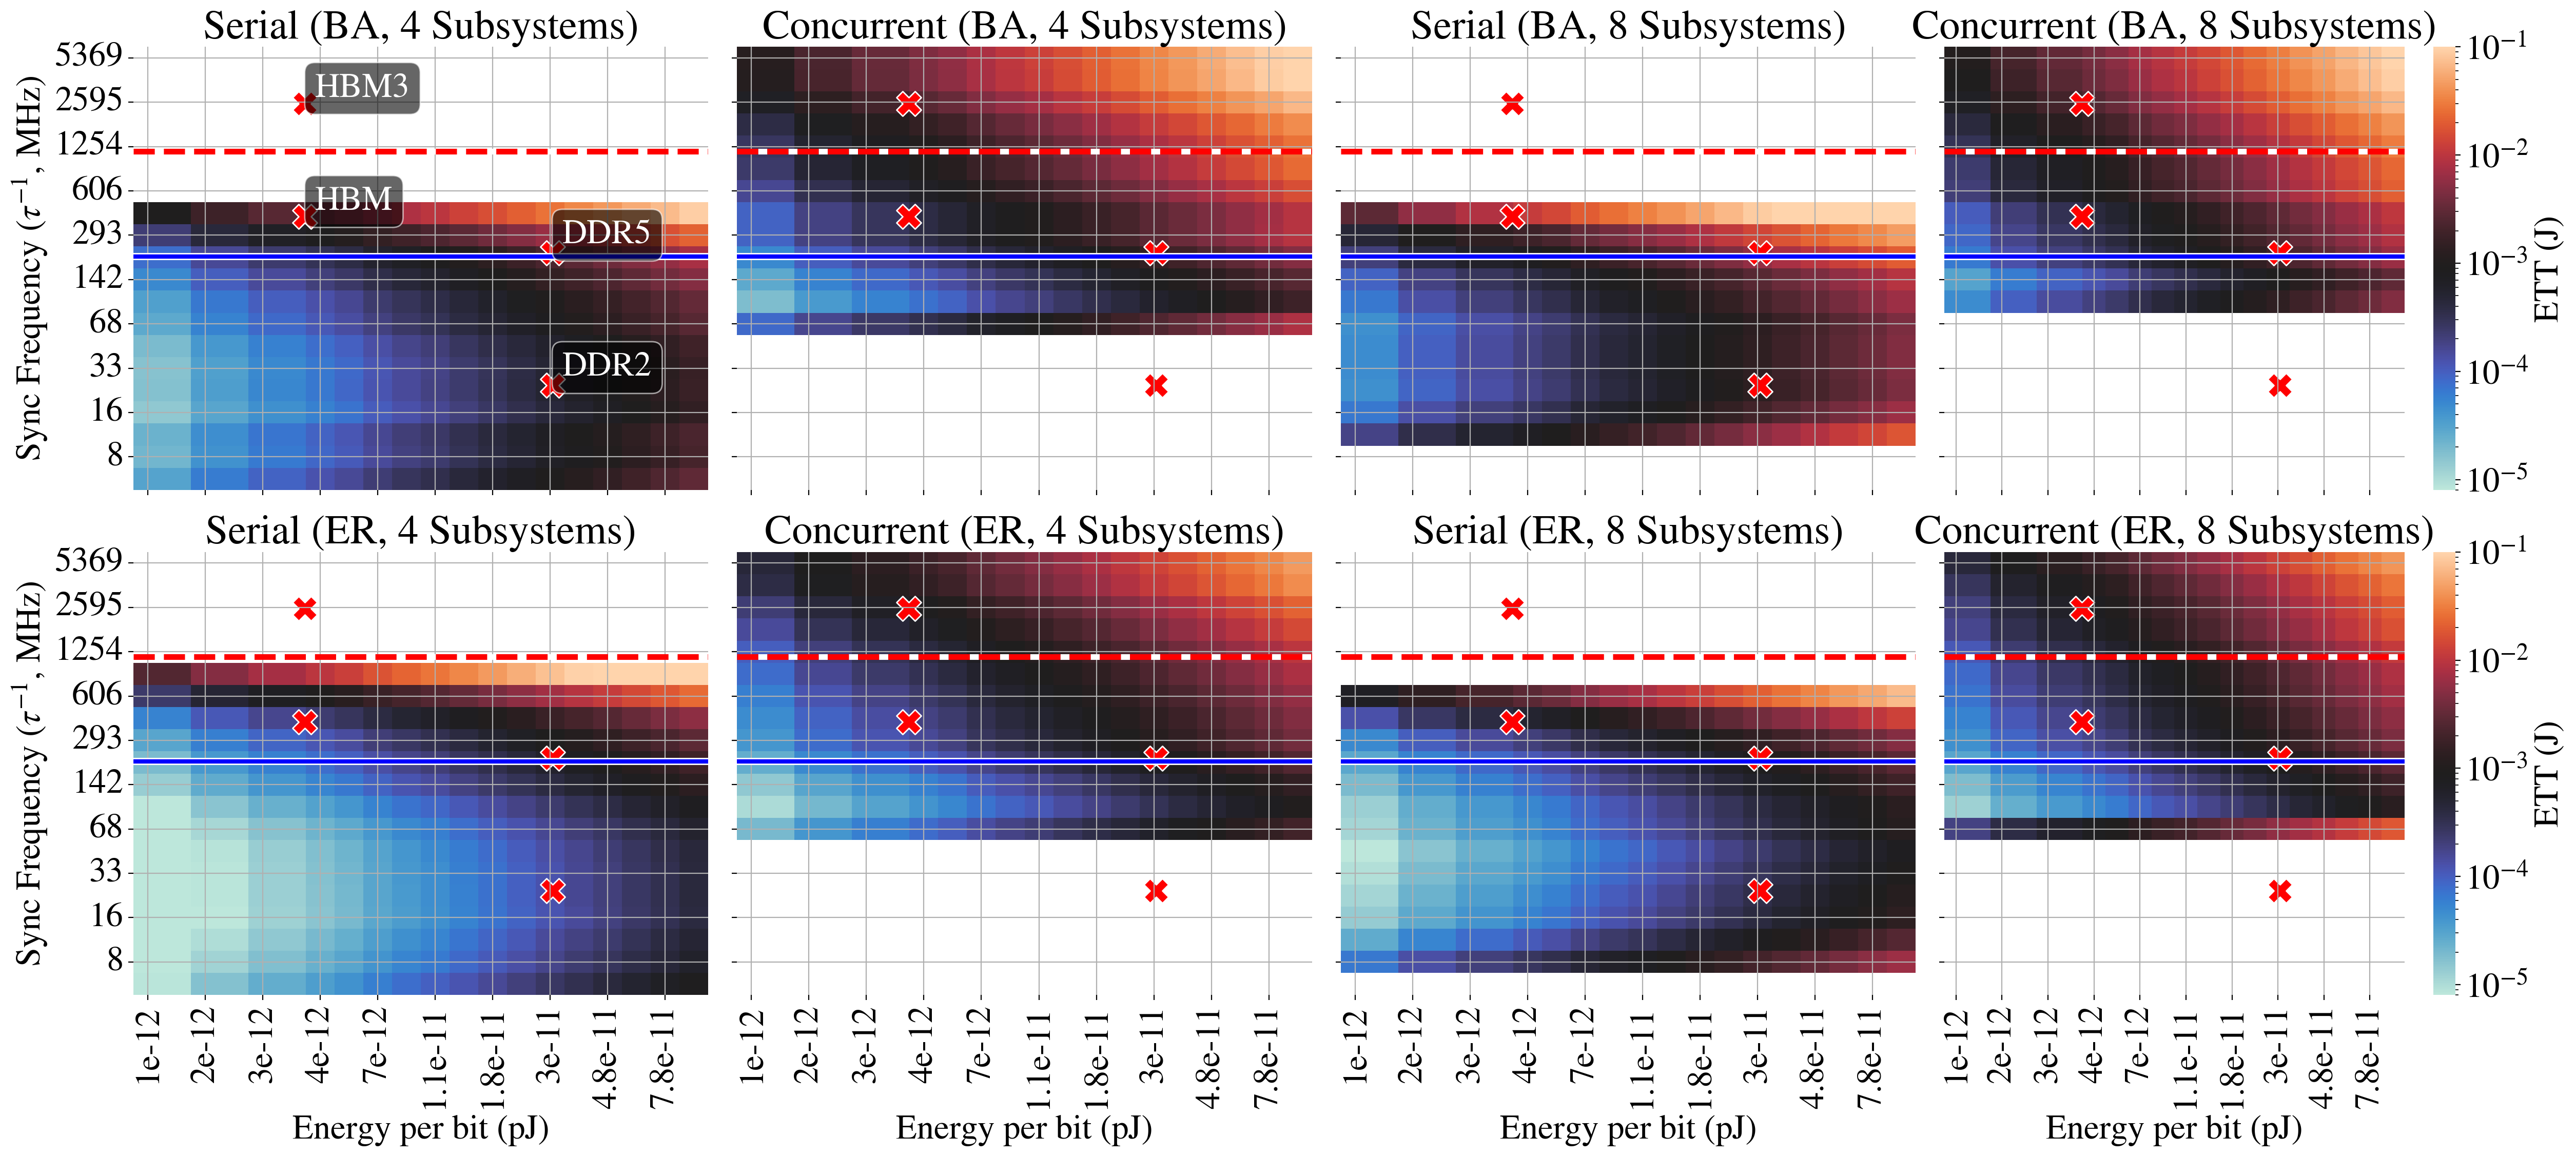

In [35]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 12),
                        gridspec_kw={'wspace': 0.05, 'hspace': 0.14})
ind = 0

comp_y = np.logspace(-12, -10, 20).round(decimals=12)

for (((c,b,t), subdf), ax)  in zip(ttt_df.groupby(['Type', 'blocks', 'concurrent']), axs.flatten()):
    comp_bits = subdf.sort_values(by='tpart').groupby(['tpart']).mean(numeric_only=True).reset_index()
    # comp_bits['tpart'] =comp_bits['tpart'] comp_bits['tpart']
    bandwidth = np.round(np.round(1 / (comp_bits['tpart']) / 1e9, decimals=4) * 1e3).astype(int)
    comp_ene = np.outer(comp_bits['BTT'], comp_y)
    # comp_ene = comp_ene.replace({np.inf: np.nan})
    vals = pd.DataFrame(data=comp_ene, index=bandwidth, columns=comp_y)
    vals = vals.replace({np.inf: np.nan})
    if ind not in {3, 7}:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='icefire', 
                    cbar=False, zorder=-1)
    else:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='icefire',  
                    cbar_kws={'label': "ETT (J)"}, zorder=-1)
    if ind not in {0, 4}:
        ax.set_yticklabels(['' for _ in ax.get_yticks()])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Sync Frequency ($\\tau^{-1}$, MHz)')
    if ind < 4:
        ax.set_xticklabels(['' for _ in ax.get_xticks()])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Energy per bit (pJ)')
    if t:
        ax.set_title('Concurrent ({}, {} Subsystems)'.format(c, b))
    else:
        ax.set_title('Serial ({}, {} Subsystems)'.format(c, b))
    ax.grid()
    yticks = ax.get_yticks()

    eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()
    xval = 20-np.interp([np.log10(1/eig1 / 1e6)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))
    ax.axhline(xval, color='white', linewidth=5, label='$\\overline{|\\lambda|}(J)$')
    ax.axhline(xval, color='blue', linewidth=3, label='$\\overline{|\\lambda|}(J)$')
    eig2 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmax'].mean()
    xval = 20-np.interp([np.log10(1/eig2 / 1e6)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))
    print(ax.get_ylim())
    ax.axhline(xval, color='red',gapcolor='white', linewidth=4, linestyle='--')
    # ind = 0
    for bw, label in zip([6553.6, 1024], ['HBM3', 'HBM']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
        # print()
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))

        locx = np.interp([np.log10(3.97e-12)], np.log10(comp_y), np.arange(20))
        ax.scatter(y=(loc), x=locx, linewidth=1, zorder=1, s=300, color='red', marker='X', edgecolor='w')
        if ind == 0:
            ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 5), textcoords='offset points', text=label, color='white',bbox=dict(facecolor='k', alpha=0.6, edgecolor='white', boxstyle='round'))
        # else:
            # ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 5), textcoords='offset points', text=label, color='white')
        # ind+=1
    # ind = 0
    for bw, label in zip([563.2, 64], ['DDR5', 'DDR2']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
    #     print(len(bandwidth), ticks)
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(len(np.log10(bandwidth)[::-1])))
        locx = np.interp([np.log10(34.42e-12)], np.log10(comp_y), np.arange(len(comp_y)))
        ax.scatter(y=(loc), x=locx, linewidth=1, zorder=1, s=300, color='red', marker='X', edgecolor='w')
        if ind == 0:
            ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 7), textcoords='offset points', text=label, color='white', bbox=dict(facecolor='k', alpha=0.6, edgecolor='white', boxstyle='round'))
        # else:
            # ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 7), textcoords='offset points', text=label, color='white',)
        # ind += 1
        
    ind+=1
fig.savefig('../figures/pra_energy.pdf', bbox_inches='tight')
plt.show()

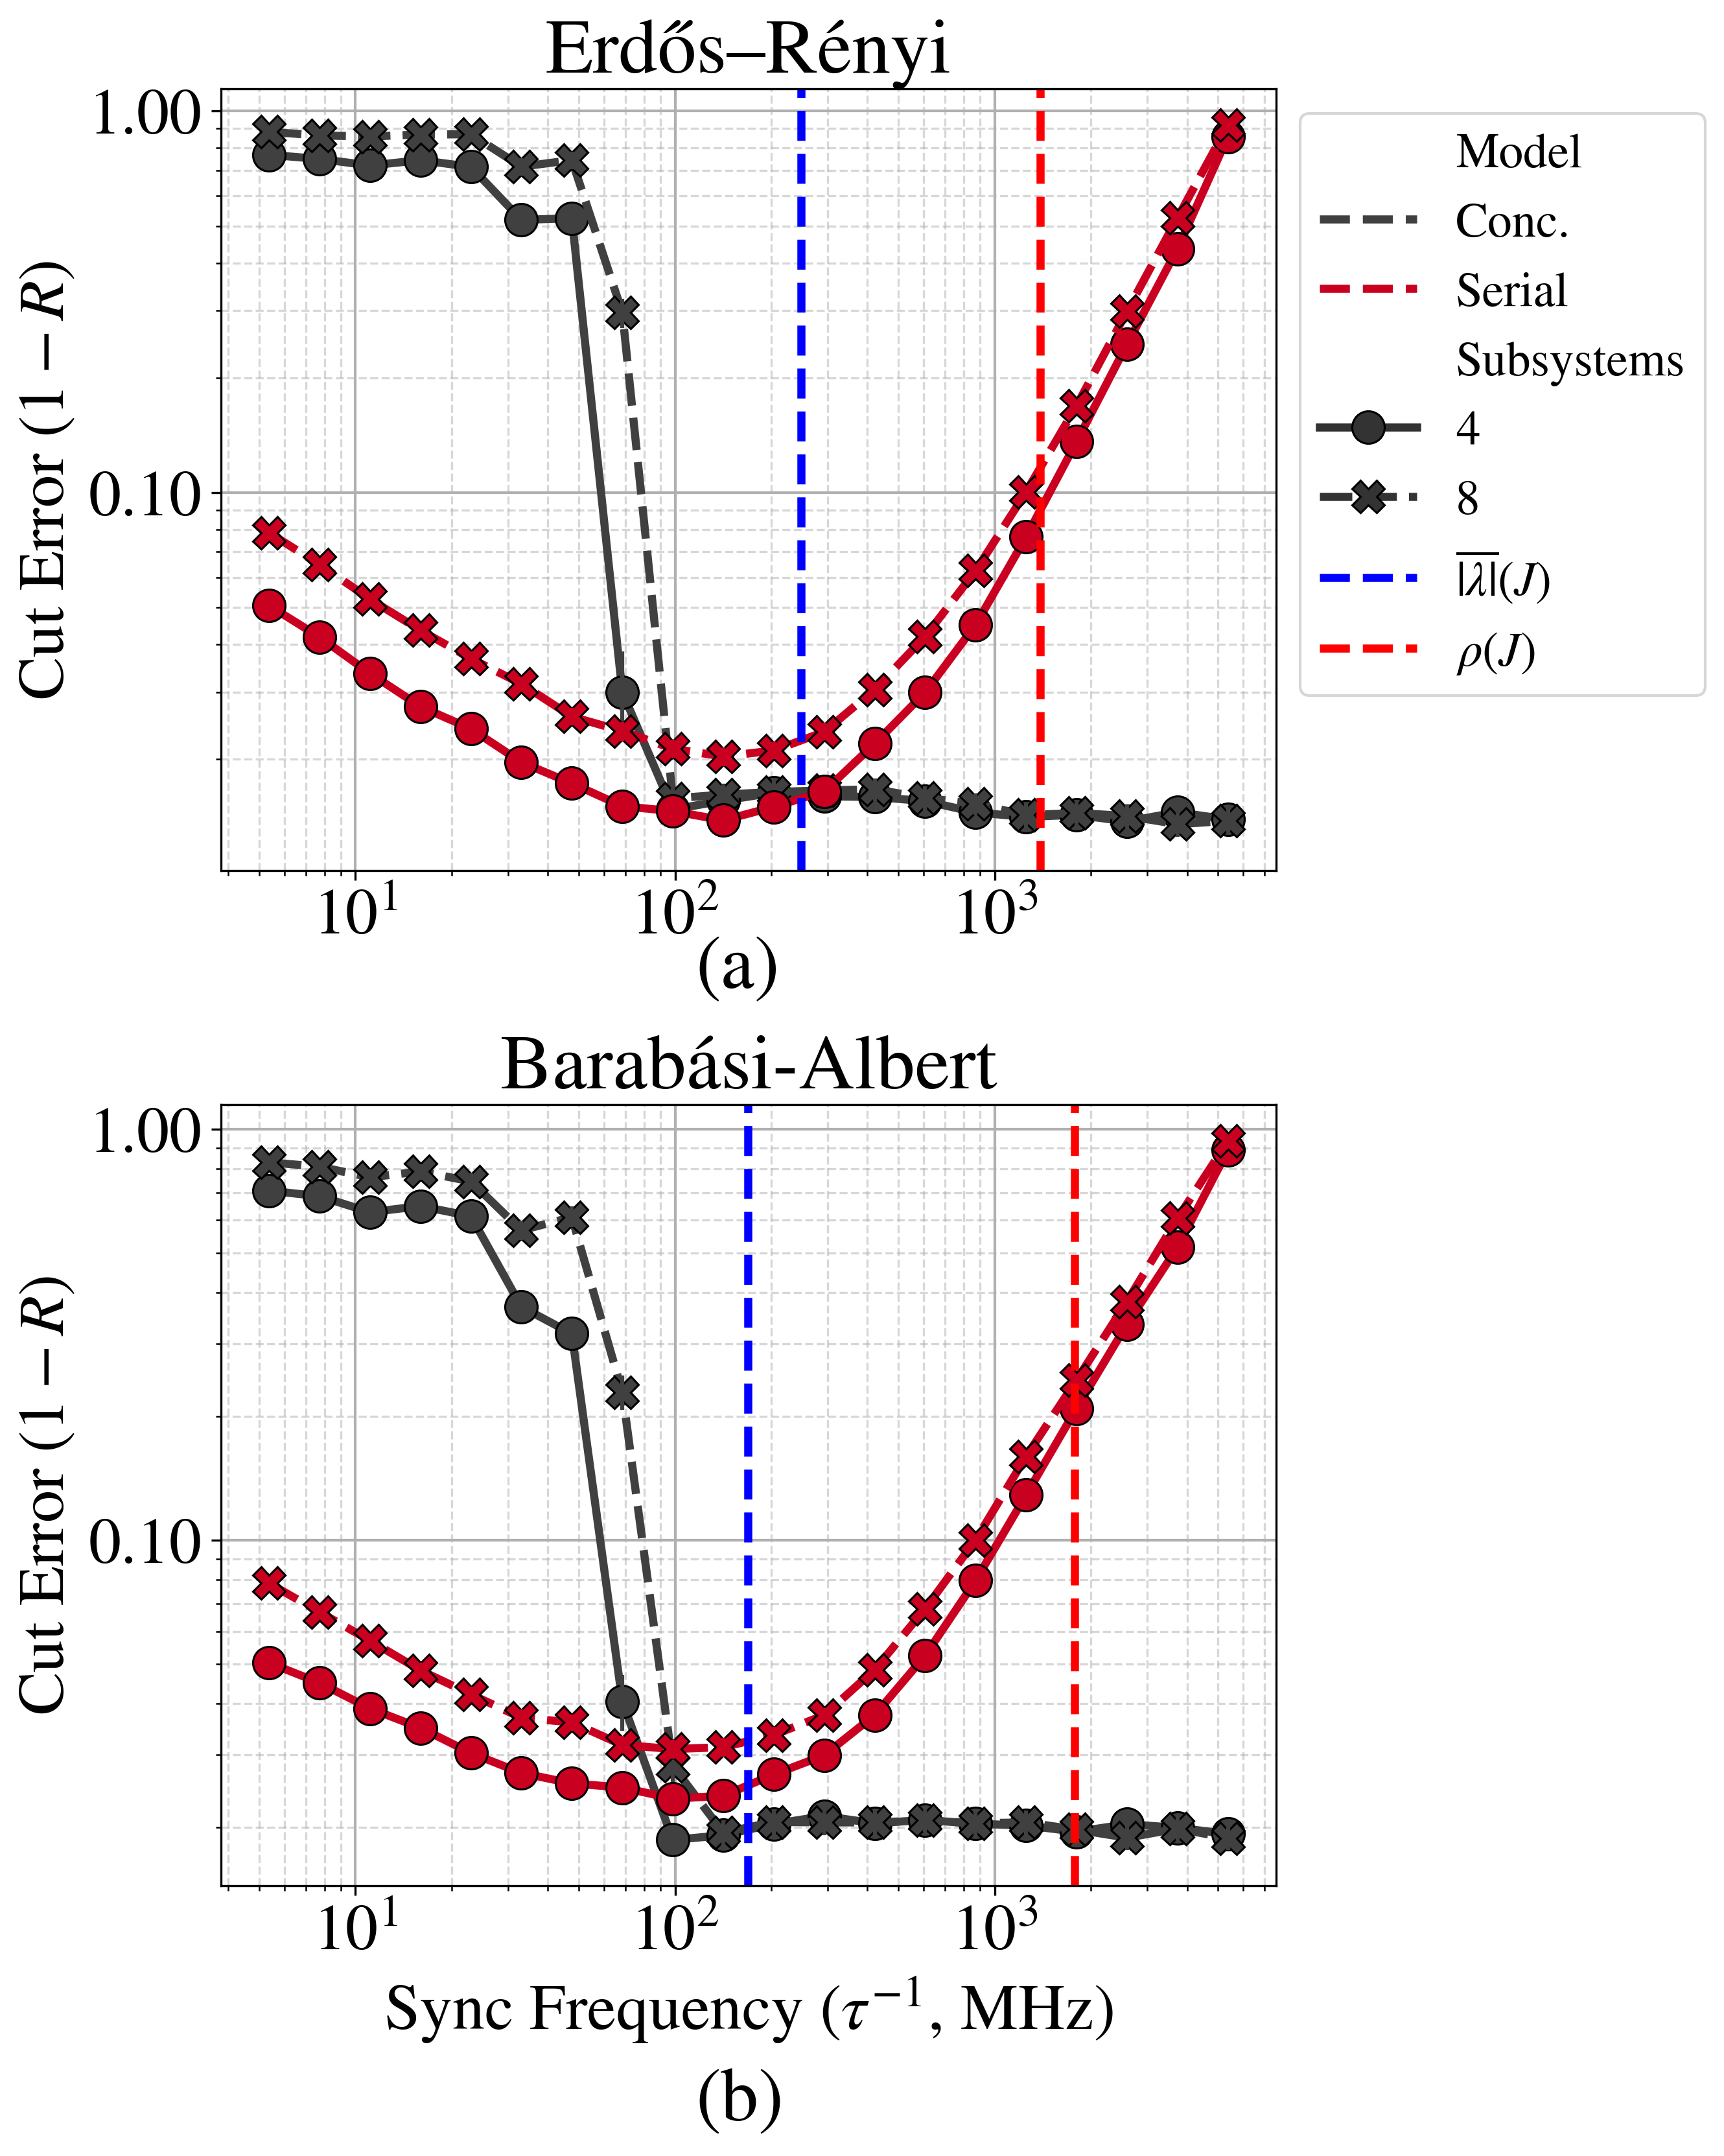

In [9]:

fig, axs = plt.subplots(nrows=2, figsize=(7, 12), gridspec_kw={'hspace': .3})
brim_df = pd.read_csv('../data/bw_vs_energy_full.csv').rename(columns={'blocks': 'Subsystems'})
brim_df['Model'] = brim_df['concurrent'].replace({True: 'Conc.', False: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df = brim_df.merge(eig_df, on='graph')
brim_df['Bandwidth'] = 1 / brim_df['tpart'] / 1e6
# brim_df['error'] = brim_df['u'] - -0.7633
line_args = dict(
    y='Inverse Ratio',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
sns.lineplot(ax=axs[0],
                data=brim_df.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df.query('GInd > 30'), 
                **line_args)
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()
axs[0].axvline(1/eig1 / 1e6, color='blue', linewidth=3, linestyle='--', label='$\\overline{|\\lambda|}(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmean'].mean()
axs[1].axvline(1/eig2 / 1e6, color='blue', linewidth=3, linestyle='--')
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmax'].mean()
axs[0].axvline(1/eig1 / 1e6, color='red', linewidth=3, linestyle='--', label='$\\rho(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmax'].mean()
axs[1].axvline(1/eig2 / 1e6, color='red', linewidth=3, linestyle='--')
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('Erdős–Rényi')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('Cut Error ($1-R$)')
   ax.grid(which='major')
axs[1].legend_ = None
for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.ScalarFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
plt.show()
fig.savefig('../figures/ba_er_cut_error.pdf', bbox_inches='tight')

In [25]:
18/1.6

11.25

In [23]:
1/((49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()) / 1e6

247.81458583147653

In [6]:

import networkx as nx
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import re
import seaborn as sns
def read_gset(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        # h /= J.abs().max()
        # J /= J.abs().max()
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G
def row_elim(mat, blocks):
    remmat = mat
    for b in blocks:
        eye = np.eye(mat.shape[0])
        eye[b,:] = 0
        # print(eye.shape)
        remmat = eye @ remmat
        remmat[:, b] *= 2
        remmat = (remmat + remmat.T)/2
    
    return remmat
G27 = read_gset(os.environ['GSET']+'/set/G028')
A = torch.tensor(nx.adjacency_matrix(G27).toarray())
blocks = np.array_split(np.arange(G27.number_of_nodes()), 8)
Aint = torch.block_diag(
    *[A[np.ix_(i,i)] for i in blocks]
)
Aext = A-Aint
eigvals, eigvecs = np.linalg.eigh(Aint)
eigvalsext, eigvecsext = np.linalg.eigh(Aext)

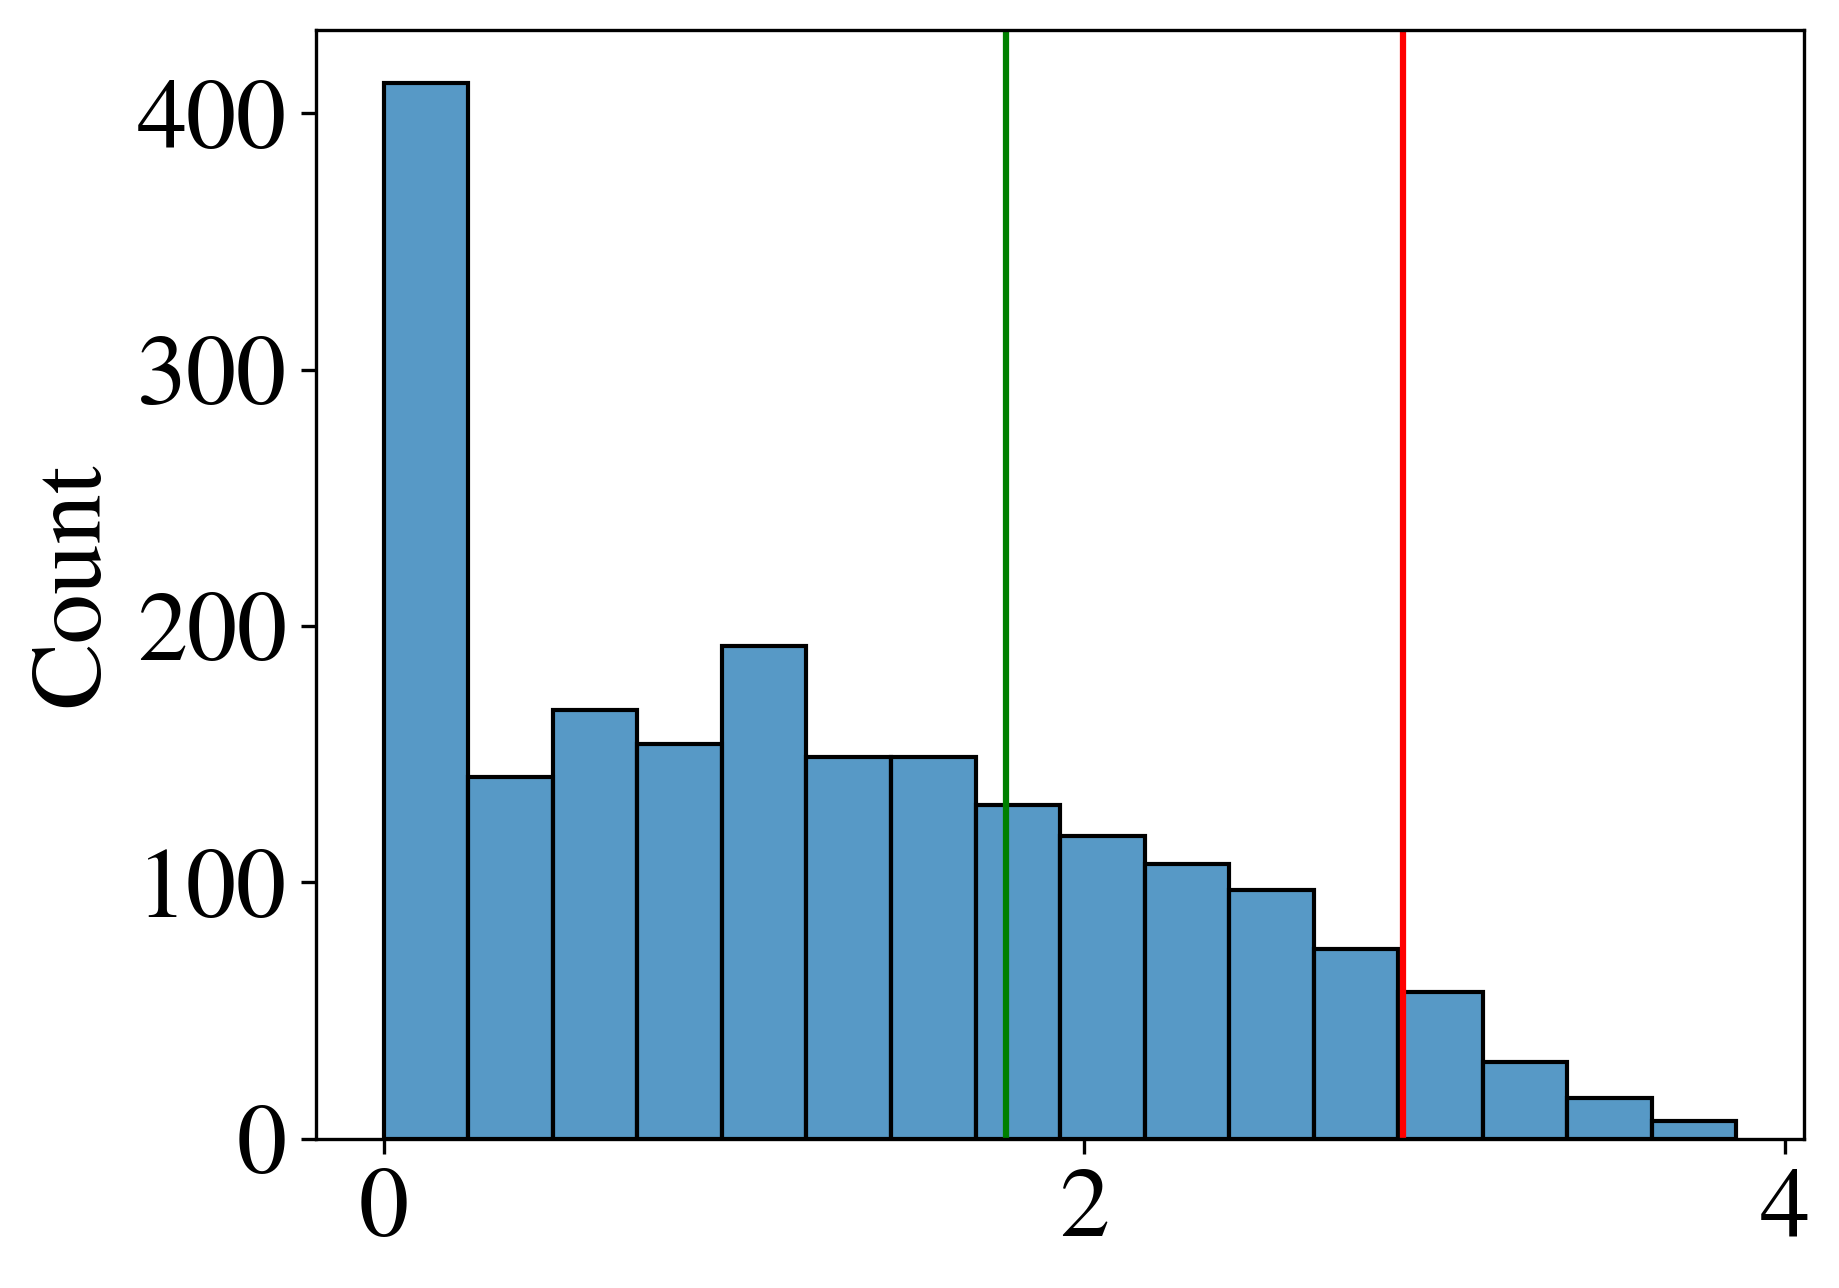

In [7]:
from scipy.stats import hmean, pmean
ax=sns.histplot(np.abs(eigvals))
ax.axvline(np.abs(pmean(np.abs(eigvals), 3)-pmean(np.abs(eigvalsext), 3)), color='red')
ax.axvline(pmean(np.abs(eigvals), 3), color='green')

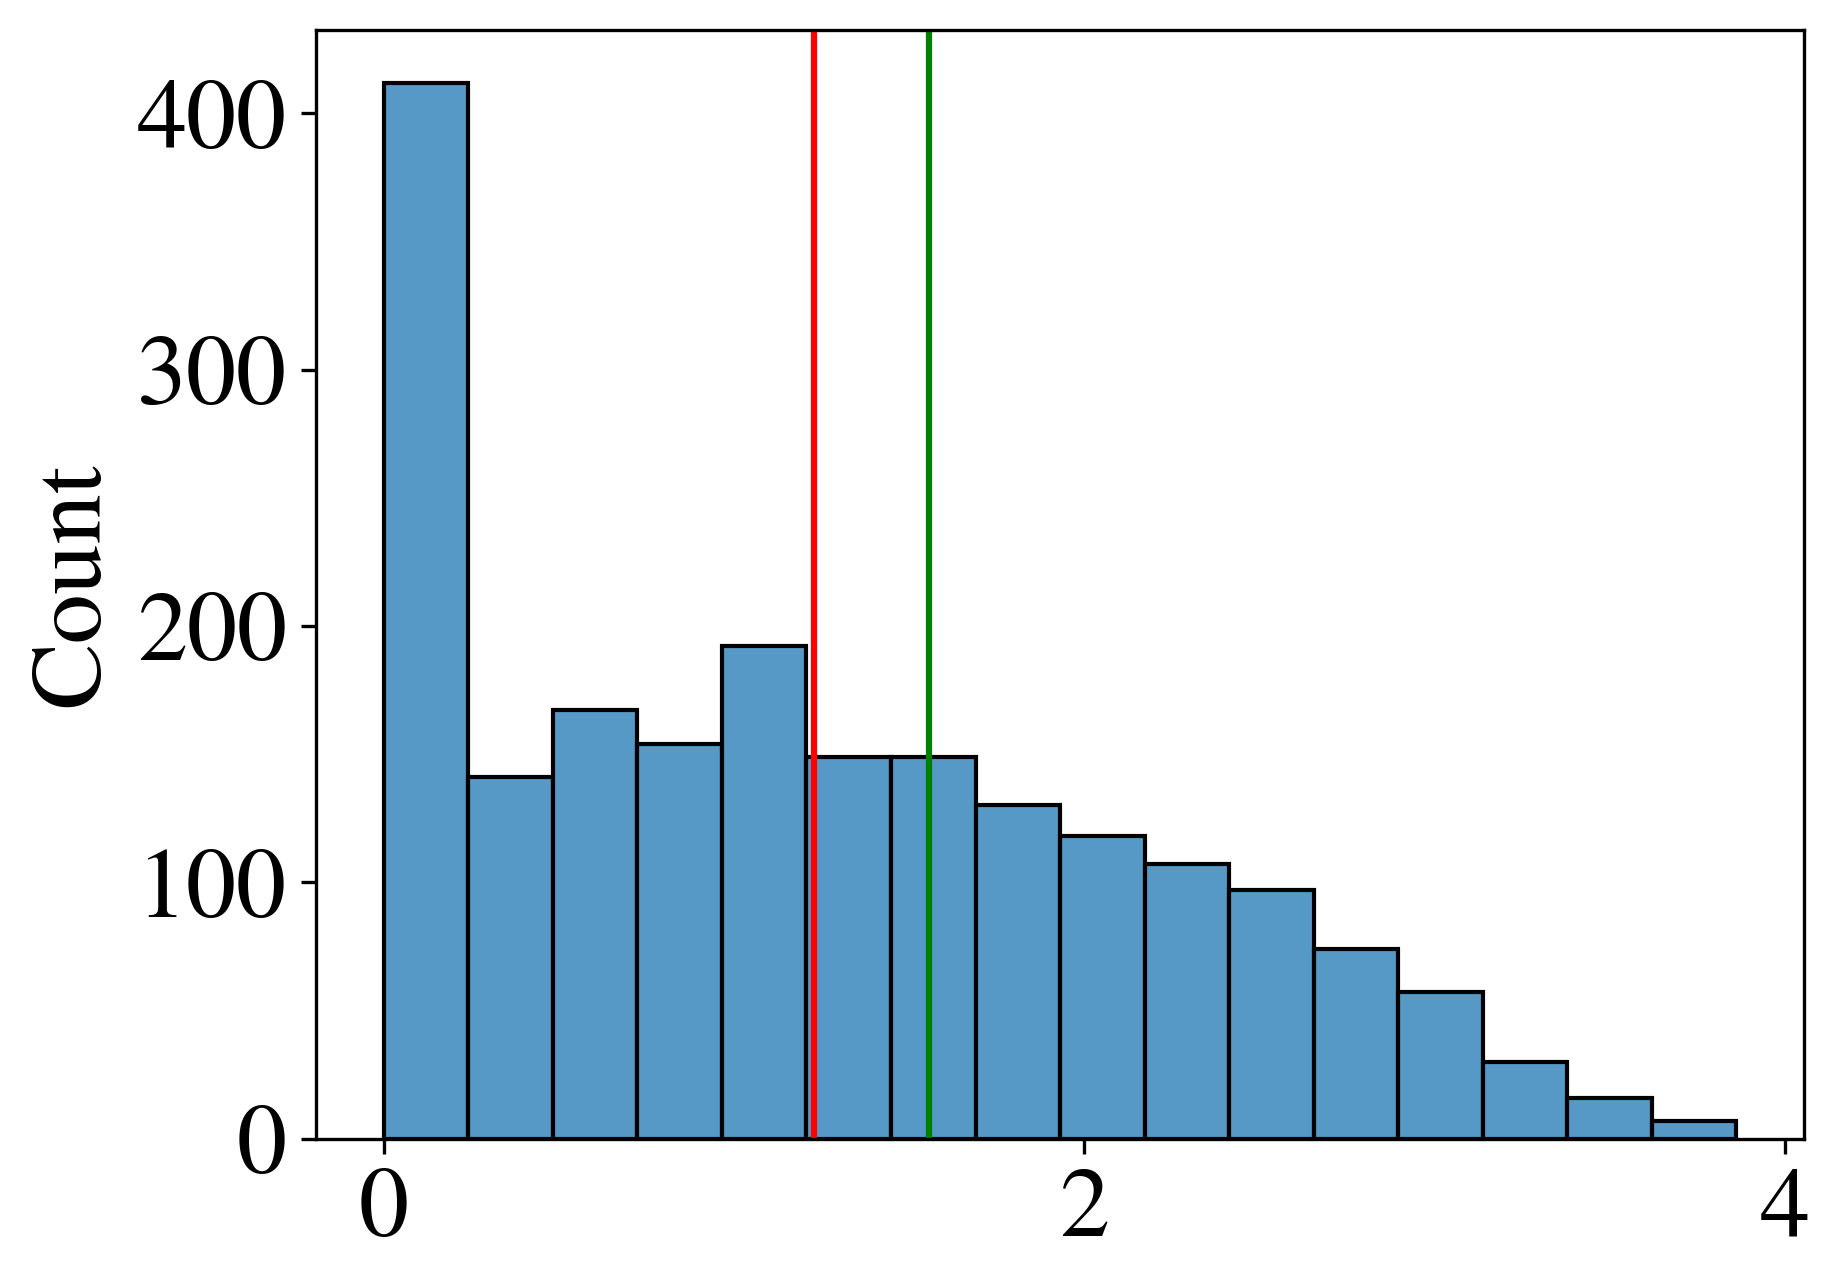

In [8]:
ax=sns.histplot(np.abs(eigvals))
ax.axvline(np.abs(eigvals).mean(), color='red')
ax.axvline(pmean(np.abs(eigvals), 2), color='green')

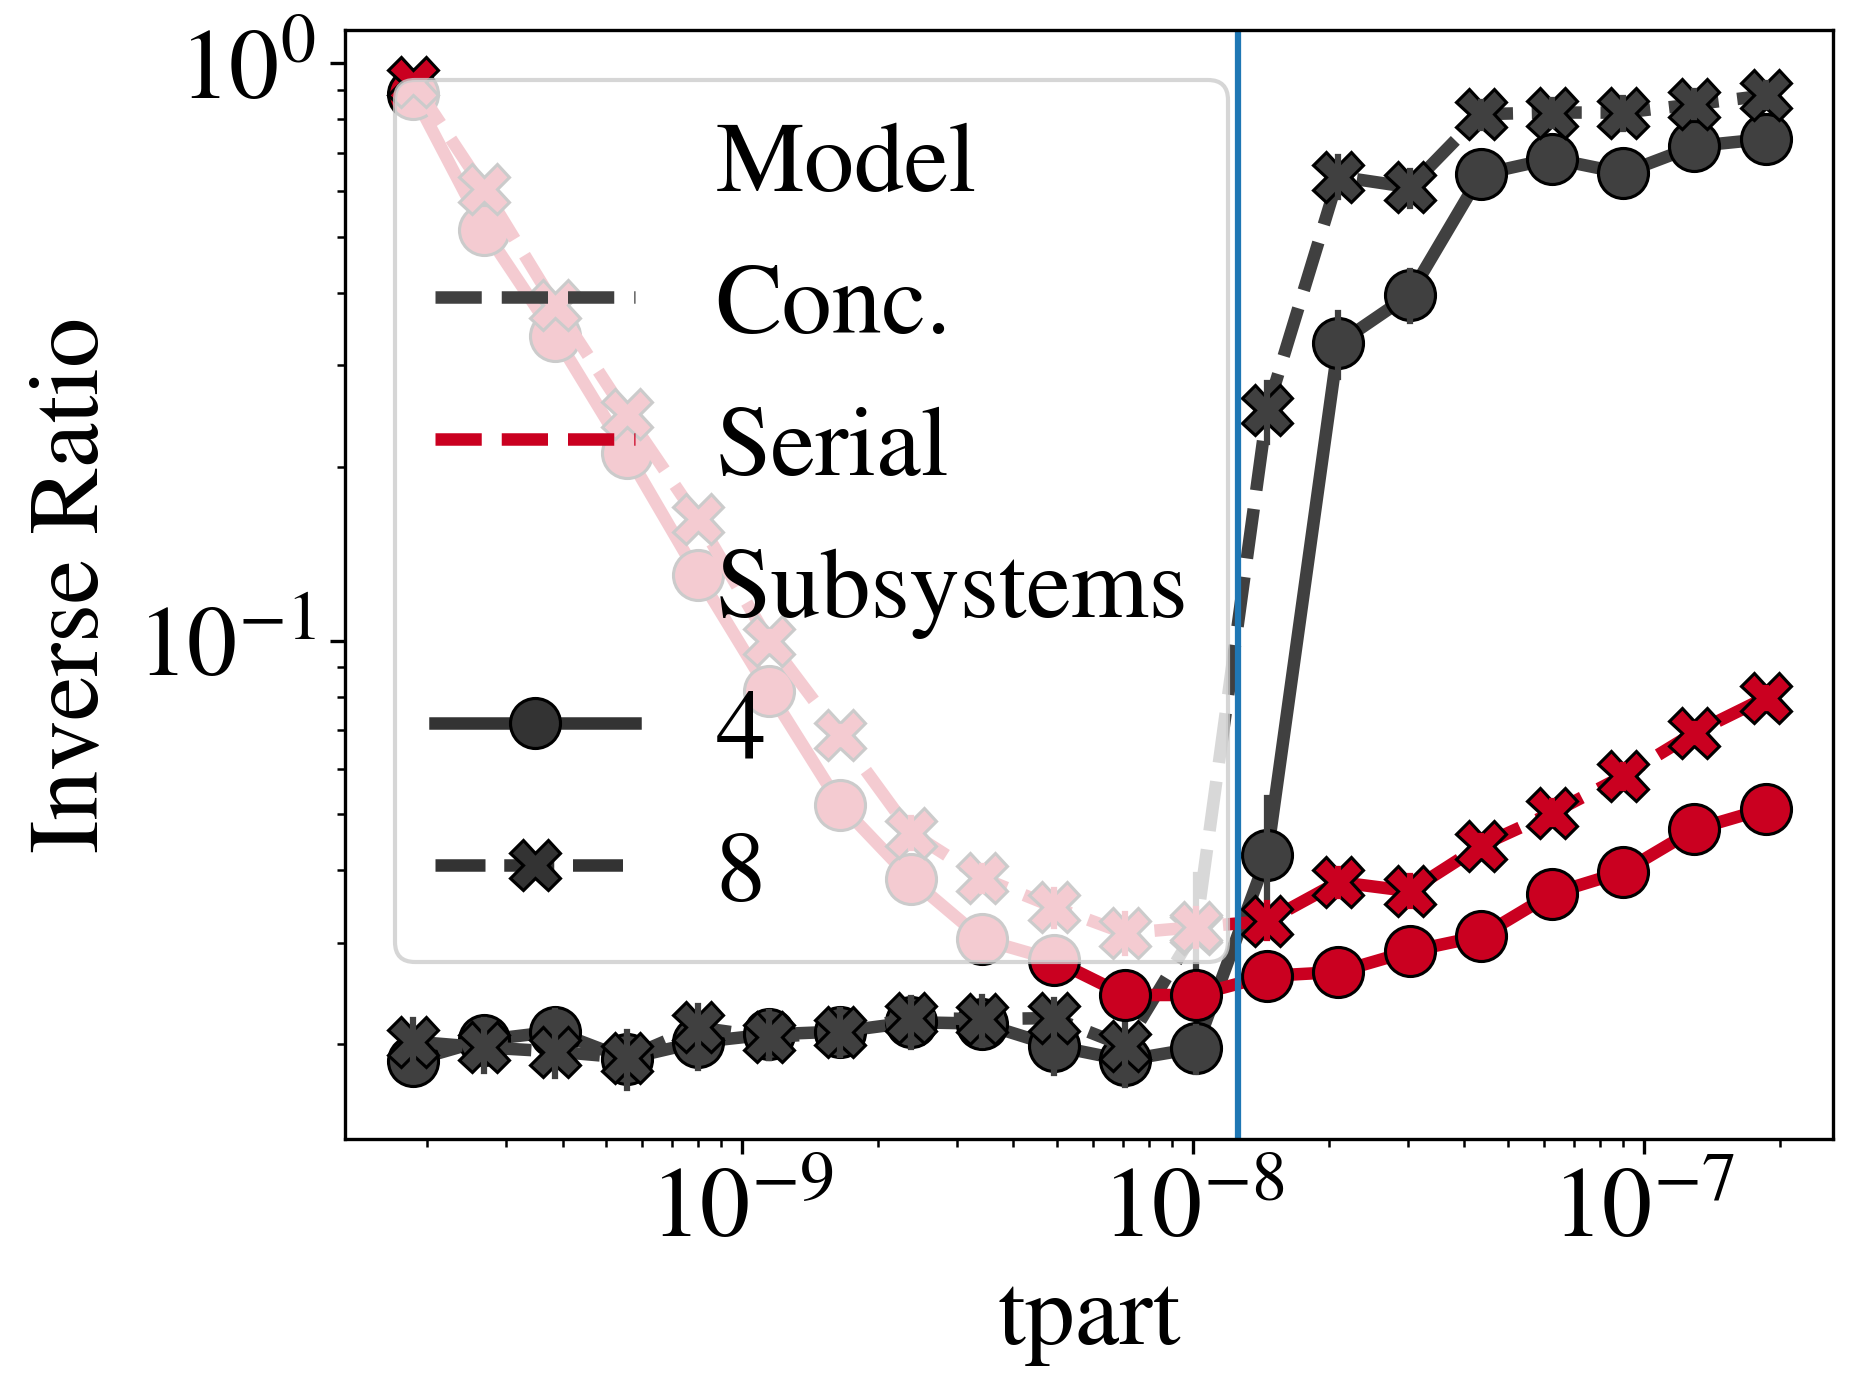

In [9]:
line_args = dict(
    y='Inverse Ratio',
    x='tpart',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
ax=sns.lineplot(
                data=brim_df.query('graph == "G041"'), 
                **line_args)
ax.axvline((31e4 * 50e-15) / (np.mean(np.abs(eigvals))))
ax.set_xscale('log')
ax.set_yscale('log')

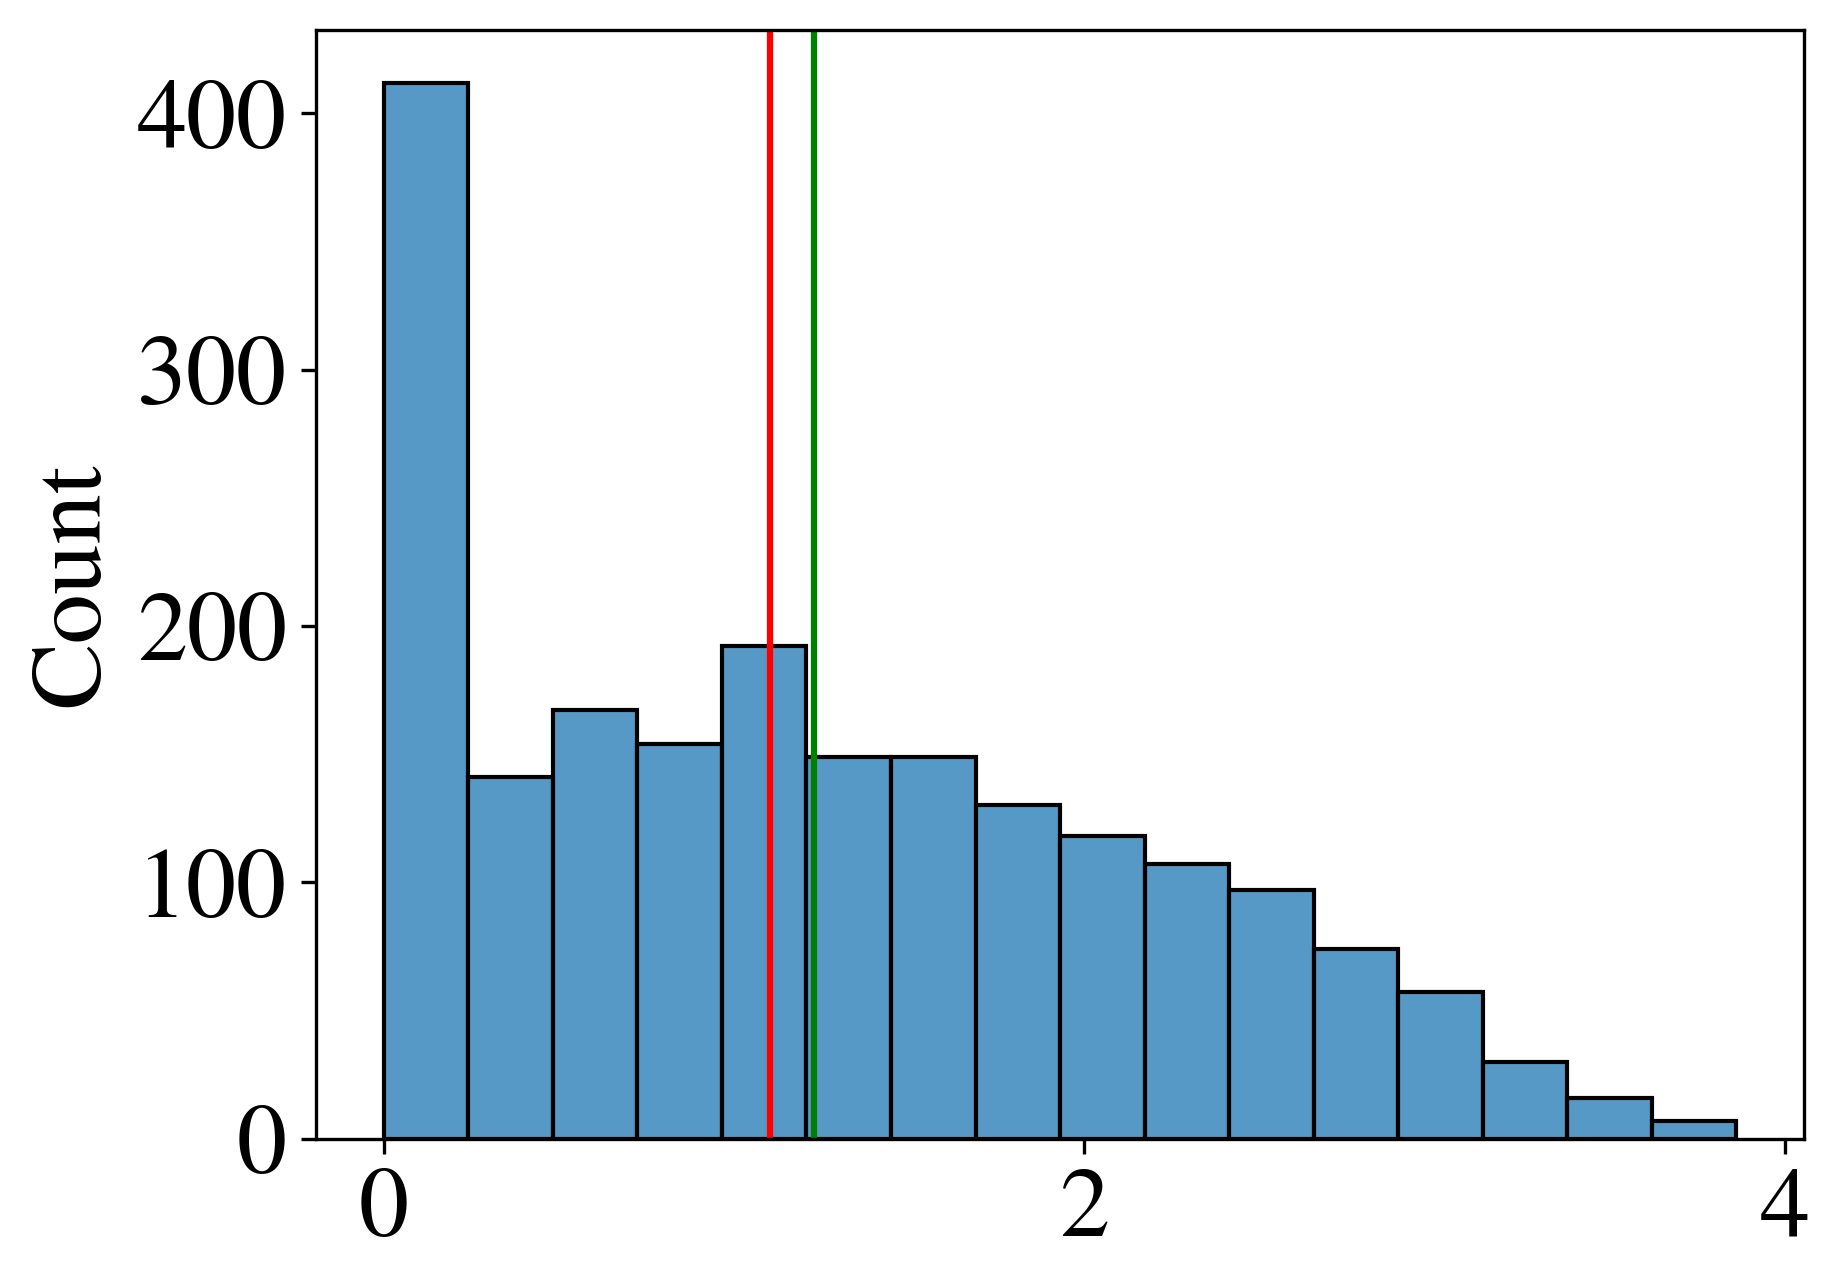

In [10]:
ax=sns.histplot(np.abs(eigvals))
ax.axvline(np.mean(np.abs(eigvals)), color='green')
ax.axvline(np.median(np.abs(eigvals)), color='red')

     level_0 graph  Subsystems Type         tpart concurrent    index  \
0          2  G028           4   ER  1.016184e-08        1.0   1979.5   
1          5  G028           8   ER  7.974603e-10        1.0  13259.5   
2          6  G028           8   ER  5.543887e-10        1.0  13499.5   
3          7  G028           8   ER  2.679322e-10        1.0  13979.5   
4          8  G028           8   ER  1.862645e-10        1.0  14219.5   
..       ...   ...         ...  ...           ...        ...      ...   
715      475  G039           4   BA  7.974603e-10        0.0      NaN   
716      476  G039           8   BA  5.543887e-10        0.0      NaN   
717      477  G039           4   BA  5.543887e-10        0.0      NaN   
718      478  G039           4   BA  3.854070e-10        0.0      NaN   
719      479  G039           8   BA  3.854070e-10        0.0      NaN   

         job  iter  scale1  ...     Ratio  GInd  Inverse Ratio          bits  \
0     1980.5  19.5     0.8  ...  0.986530  

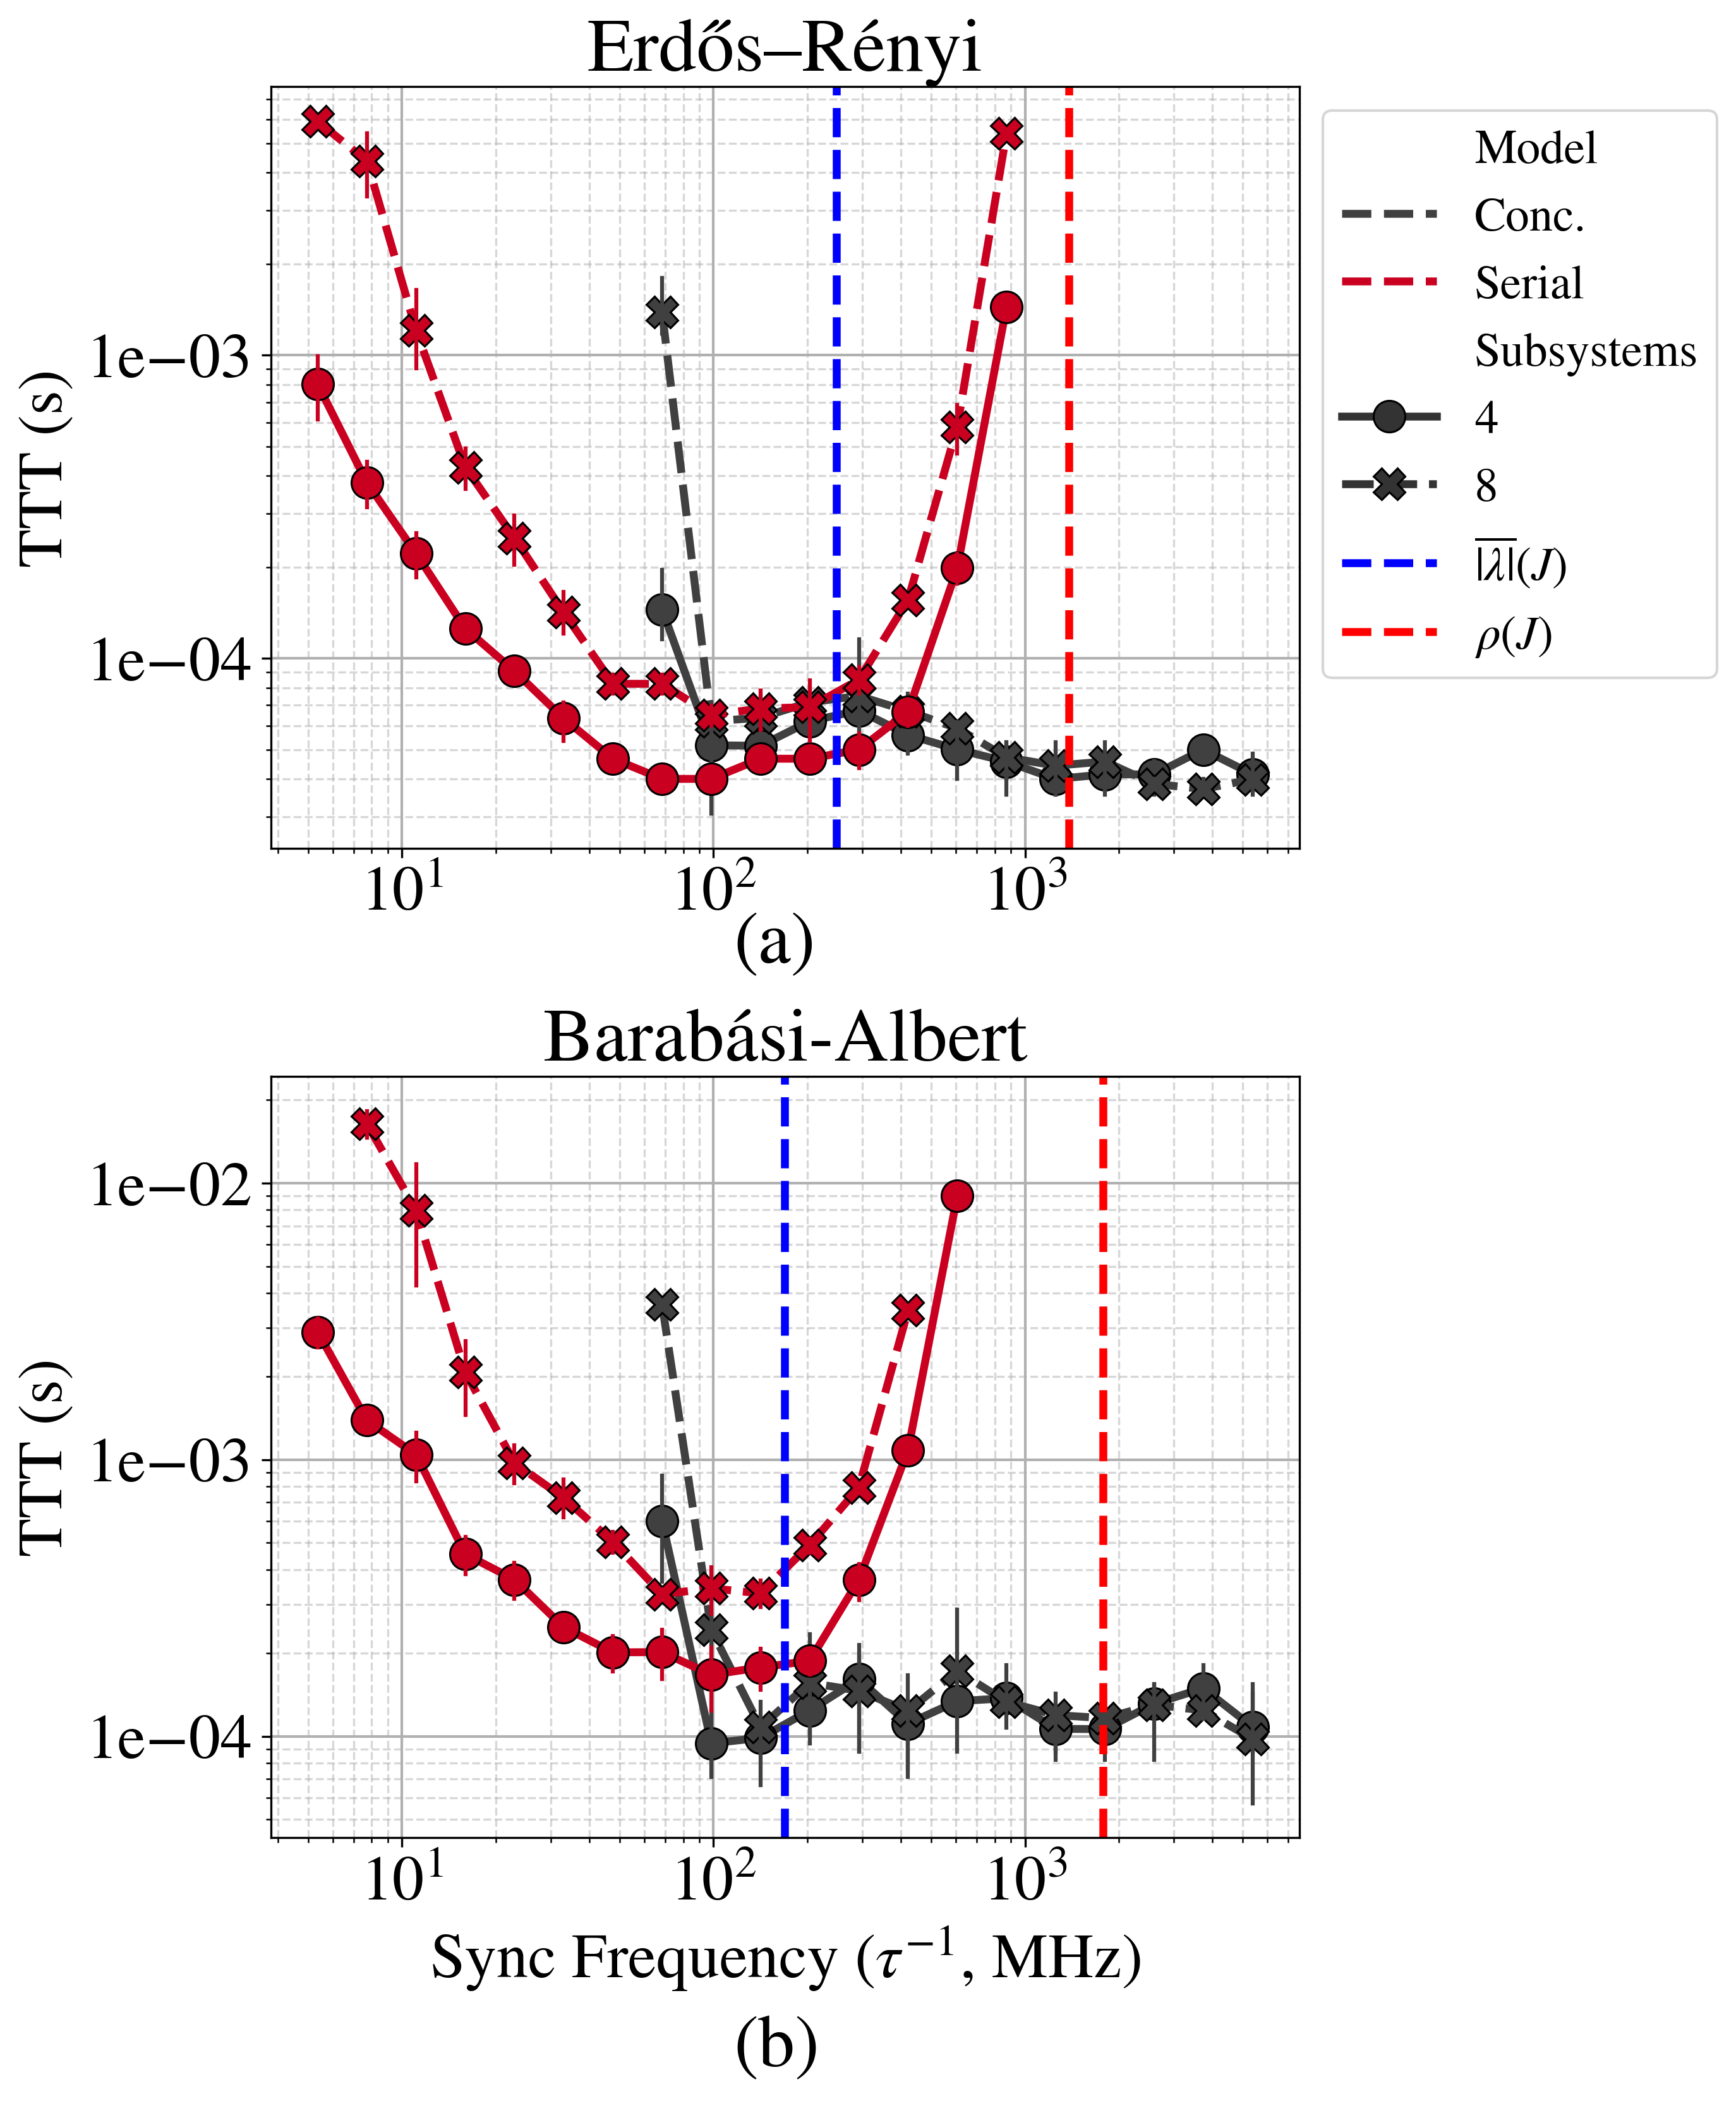

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 12), gridspec_kw={'hspace': .3})
brim_df = pd.concat([ pd.read_csv('../data/bw_vs_energy_ttt98.csv').query('concurrent == 1'), pd.read_csv('../data/bw_vs_energy_longer_ttt.csv')]).reset_index()
brim_df = brim_df.rename(columns={'blocks': 'Subsystems'})
print(brim_df)
# brim_df = pd.read_csv('../data/bw_vs_energy_ttt98.csv').rename(columns={'blocks': 'Subsystems'})
brim_df['Model'] = brim_df['concurrent'].replace({1.0: 'Conc.', 0.0: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df['Bandwidth'] = 1 / brim_df['tpart'] / 1e6
# brim_df['error'] = brim_df['u'] - -0.7633
line_args = dict(
    y='TTT',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
brim_df = brim_df.sort_values(by=['Model', 'Subsystems'])
sns.lineplot(ax=axs[0],
                data=brim_df.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df.query('GInd > 30'), 
                **line_args)

eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmean'].mean()
axs[0].axvline(1/eig1 / 1e6, color='blue', linewidth=3, linestyle='--', label='$\\overline{|\\lambda|}(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmean'].mean()
axs[1].axvline(1/eig2 / 1e6, color='blue', linewidth=3, linestyle='--')
eig1 = (49e-15 * 31e4) / eig_df.query('type == "ER"')['eigmax'].mean()
axs[0].axvline(1/eig1 / 1e6, color='red', linewidth=3, linestyle='--', label='$\\rho(J)$')
eig2 = (49e-15 * 31e4) / eig_df.query('type == "BA"')['eigmax'].mean()
axs[1].axvline(1/eig2 / 1e6, color='red', linewidth=3, linestyle='--')
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('Erdős–Rényi')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')

for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('TTT (s)')
   ax.grid(which='major')
axs[1].legend_ = None
for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[1,2,3,4,5,6,7,8,9]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.LogFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
plt.show()
fig.savefig('../figures/ba_er_ttt.pdf', bbox_inches='tight')